In [140]:
import torch
import torch.nn as nn
from tqdm import tqdm
import torch.optim as optim
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score,roc_curve,auc
from sklearn.datasets import make_classification

import matplotlib.pyplot as plt

### 1. 数据生成

In [141]:

# 生成模拟数据
def generate_data(config):
    # 类别型特征（假设有3个类别特征）
    np.random.seed(config.random_state)
    
    cat_feat1 = np.random.randint(0, 10, config.num_samples)  # 10个类别
    cat_feat2 = np.random.randint(0, 5, config.num_samples)   # 5个类别
    cat_feat3 = np.random.randint(0, 8, config.num_samples)   # 8个类别
        
    # 拼接特征
    X_cat = np.stack([cat_feat1, cat_feat2, cat_feat3], axis=1)
    
    #生成数特征和标签
    X_num, y = make_classification(
        n_samples=config.num_samples,
        n_features=2,  # 生成2个数值特征
        n_informative=2,
        n_redundant=0,
        random_state=config.random_state
    )
    
    return X_cat, X_num, y

### 2. 模型构建
残差连接的核心思想是允许网络学习输入和输出之间的残差(差异).具体来说,如果输入是x,输出为F(x),那么残差连接的目标是学习F(x)-x网络可以更容易的学习到输入和输出之间的差异,而不是直接学习输出F(x)

In [142]:
#残差网络块
class ResidualUnit(nn.Module):
    def __init__(self, input_dim, hidden_dim, dropout_rate):
        super(ResidualUnit, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, input_dim),
            nn.BatchNorm1d(input_dim),
            nn.Dropout(dropout_rate)
        )
    
    def forward(self, x):
        return nn.ReLU(x + self.layers(x))
    

In [143]:
class DeepCrossing(nn.Module):
    def __init__(self, cat_sizes, num_sizes, config):
        super(DeepCrossing, self).__init__()

        #Embedding层
        self.embeddings = nn.ModuleList([
            nn.Embedding(size, config.embedding_dim ) for size in cat_sizes #生成对应 Embedding层    
        ])

        #计算总特征维度
        total_dim = len(cat_sizes) * config.embedding_dim + num_sizes

        #多层Residual units
        self.res_uint = nn.Sequential()
        for _ in range(config.num_residual_units):
            self.res_uint.append(
                ResidualUnit(total_dim, config.hidden_dim, config.dropout_rate)
            )

        #scoring层
        self.fc = nn.Linear(total_dim,1)

    def forward(self, x_cat, x_num):
        #处理类别特征,注意x_cat 每一列都是一个类别特征,采用类似Ordinal Encoder
        embeddings = []
        for i in range(len(self.embeddings)):
            embeddings.append(self.embeddings[i](x_cat[:,i]))
        
        x = torch.cat(embeddings, dim = 1) #拼接起来

        #拼接数值特征
        x = torch.cat([x,x_num], dim = 1)

        #残差单元
        x = self.res_uint(x)

        #输出层
        return torch.sigmoid(self.fc(x)).squeeze()
        
        

### 3. 数据预处理

In [144]:
#数据预处理
def prepare_data(X_cat, X_num, y, config):
    #转换为Tensor
    X_cat = torch.LongTensor(X_cat)
    X_num = torch.FloatTensor(X_num)
    y = torch.FloatTensor(y)

    return train_test_split(
        X_cat, X_num, y,
        test_size = config.test_size,
        random_state = config.random_state
    )

### 4. 配置参数和初始化模型

In [145]:
# 配置参数
class Config:
    num_samples = 10000
    embedding_dim = 8
    hidden_dim = 32
    num_residual_units = 3
    dropout_rate = 0.2
    test_size = 0.2
    random_state = 42
    epoch = 100

config = Config()
X_cat, X_num, y = generate_data(config)

(X_cat_train, X_cat_test, 
 X_num_train, X_num_test
 ,y_train, y_test) = prepare_data(X_cat, X_num, y, config)

#初始化模型
cat_sizes = [10, 5, 8]  # 对应各个类别特征的类别数量
num_sizes = X_num.shape[1]
model = DeepCrossing(cat_sizes = cat_sizes, num_sizes = num_sizes, config = config)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

print(model)

DeepCrossing(
  (embeddings): ModuleList(
    (0): Embedding(10, 8)
    (1): Embedding(5, 8)
    (2): Embedding(8, 8)
  )
  (res_uint): Sequential(
    (0): ResidualUnit(
      (layers): Sequential(
        (0): Linear(in_features=26, out_features=32, bias=True)
        (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Dropout(p=0.2, inplace=False)
        (4): Linear(in_features=32, out_features=26, bias=True)
        (5): BatchNorm1d(26, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (6): ReLU()
        (7): Dropout(p=0.2, inplace=False)
      )
    )
    (1): ResidualUnit(
      (layers): Sequential(
        (0): Linear(in_features=26, out_features=32, bias=True)
        (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Dropout(p=0.2, inplace=False)
        (4): Linear(in_features=32, out_features=26, bias=True)
        (5):

### 5. 模型训练

In [146]:
# 训练和测试
pbar = tqdm(range(config.epoch), desc='Training')
loss_history = []
test_loss_history = []
train_auc_history = []
test_auc_history = []

for epoch in pbar:
    model.train()  # 切换到训练模式
    optimizer.zero_grad()

    outputs = model(X_cat_train, X_num_train)
    loss = criterion(outputs, y_train)
    loss_history.append(loss.item())

    loss.backward()
    optimizer.step()

    model.eval()  # 切换到评估模式
    with torch.no_grad():
        test_outputs = model(X_cat_test, X_num_test)
        test_loss = criterion(test_outputs, y_test)
        test_loss_history.append(test_loss.item())

        # 计算 AUC 分数
        train_auc = roc_auc_score(y_train.numpy(), outputs.detach().numpy())
        test_auc = roc_auc_score(y_test.numpy(), test_outputs.detach().numpy())
        train_auc_history.append(train_auc)
        test_auc_history.append(test_auc)

    pbar.set_postfix({'train_loss': f'{loss.item():.4f}', 'test_loss': f'{test_loss.item():.4f}',
                      'train_auc': f'{train_auc:.4f}', 'test_auc': f'{test_auc:.4f}'})


Training: 100%|██████████| 100/100 [00:03<00:00, 32.35it/s, train_loss=0.2640, test_loss=0.2599, train_auc=0.9550, test_auc=0.9568]


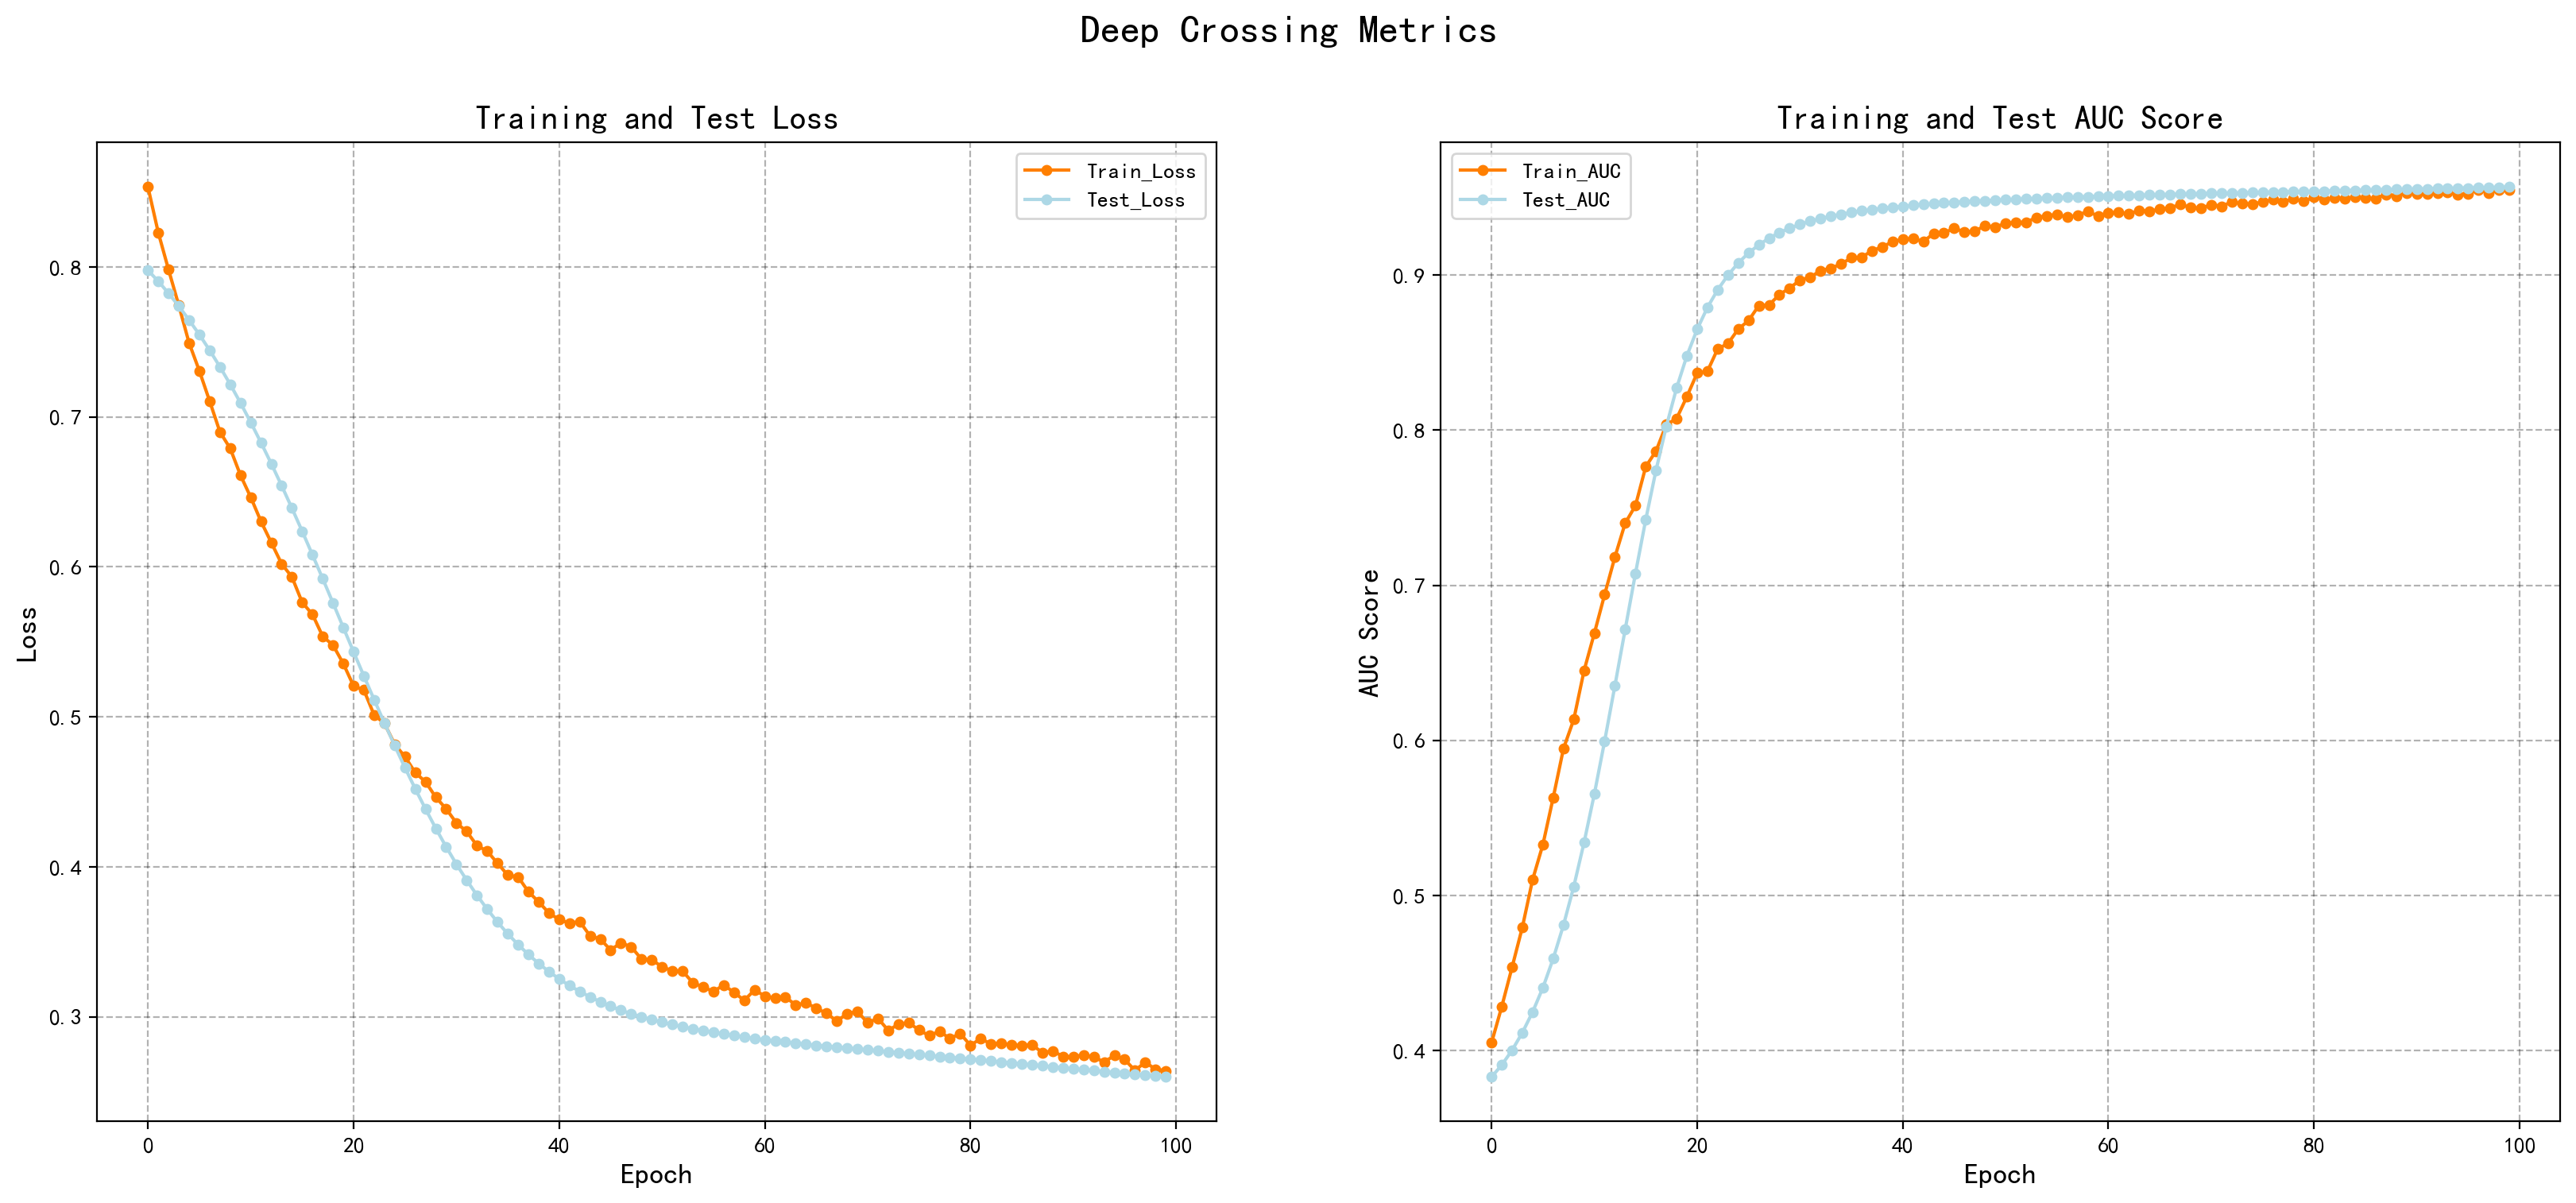

In [147]:
# 模型评估
fig, ax = plt.subplots(1, 2, figsize=(20, 8), dpi=200)
ax = ax.flatten()

# 绘制训练和测试损失
ax[0].set_title('Training and Test Loss', weight='bold', fontsize=15)
ax[0].set_xlabel('Epoch', fontsize=13)
ax[0].set_ylabel('Loss', fontsize=13)
ax[0].grid(linestyle='--', alpha=0.3, color='black')
ax[0].plot(loss_history, color='#FF7F00', label='Train_Loss', zorder=2, marker='o', markersize=4)
ax[0].plot(test_loss_history, color='lightblue', label='Test_Loss', zorder=2, marker='o', markersize=4)
ax[0].legend()

# 绘制训练和测试 AUC 分数
ax[1].set_title('Training and Test AUC Score', weight='bold', fontsize=15)
ax[1].set_xlabel('Epoch', fontsize=13)
ax[1].set_ylabel('AUC Score', fontsize=13)
ax[1].grid(linestyle='--', alpha=0.3, color='black', zorder=0)
ax[1].plot(train_auc_history, color='#FF7F00', label='Train_AUC', zorder=2, marker='o', markersize=4)
ax[1].plot(test_auc_history, color='lightblue', label='Test_AUC', zorder=2, marker='o', markersize=4)
ax[1].legend()

fig.suptitle('Deep Crossing Metrics', fontsize=18, fontweight='bold')

plt.show()